# 載入所需套件

In [1]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.dates as mdates
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas_datareader as pdr
from datetime import datetime

#設定字體和解決圖像中文顯示問題
plt.rcParams['font.sans-serif']=['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus']=False

register_matplotlib_converters()
%matplotlib inline

# 定義抓取股票清單股價資料函數

In [2]:
def get_price_df(start,end,company_list,code_list):
    
    stock_price,adjclose={},{}
    
    for i,j in zip(company_list,code_list):
        print(j,i)
        df=pdr.DataReader('{}.TW'.format(j),'yahoo',start=start,end=end)
        stock_price[i]=df
        adjclose[i]=df['Adj Close']
        
    adjclose_df=pd.DataFrame(adjclose)
    
    return stock_price,adjclose_df

# 定義繪製股票清單相關係數熱度圖函數

In [3]:
def plot_corr_heatmap(adjclose):
    
    fig,ax=plt.subplots(1,figsize=(8,6))
    sns.heatmap(adjclose.corr(),annot=True,cmap='coolwarm',annot_kws={'size':15},ax=ax)
    ax.tick_params(axis='y',labelsize=15,rotation=0)
    ax.tick_params(axis='x',labelsize=15)
    ax.xaxis.tick_top()    

# 定義繪製配對交易股票價格函數

In [4]:
def plot_pair_stock_price(stock_1,stock_2):
    
    fig,ax=plt.subplots(1,figsize=(15,6))
    ax2=ax.twinx()
    ax.plot(adjclose.index,adjclose[stock_1],label=stock_1)
    ax2.plot(adjclose.index,adjclose[stock_2],label=stock_2,color='#ff7f0e')
    lines=ax.get_lines()+ax2.get_lines()
    ax.legend(lines,[line.get_label() for line in lines],fontsize=12,loc='upper left')
    ax.set_title('{} & {} 調整後收盤價'.format(stock_1,stock_2),fontsize=20)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=8))
    ax.tick_params(axis='x',labelsize=10)
    ax.tick_params(axis='y',labelsize=12)
    ax2.tick_params(axis='y',labelsize=12)
    ax.grid()

# 定義繪製和計算Spread_Ratio函數

In [5]:
def plot_spread_ratio(stock_1,stock_2,window,crit):
    
    Spread_Ratio=adjclose[stock_1]/adjclose[stock_2]
    Spread_Ratio_MA=Spread_Ratio.rolling(window).mean()
    Spread_Ratio_rolling_Std=Spread_Ratio.rolling(window).std()
    upper_bound=Spread_Ratio_MA+crit*Spread_Ratio_rolling_Std
    lower_bound=Spread_Ratio_MA-crit*Spread_Ratio_rolling_Std


    fig,ax=plt.subplots(1,figsize=(15,6))
    ax.plot(Spread_Ratio,label='價格比率')
    ax.plot(Spread_Ratio_MA,label='{}日移動平均'.format(window),linestyle='--',color='k')
    ax.plot(upper_bound,label='上界',linestyle='--',color='g')
    ax.plot(lower_bound,label='下界',linestyle='--',color='r')
    ax.set_title('{} / {} 價格比率'.format(stock_1,stock_2),fontsize=20)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=8))
    ax.tick_params(axis='x',labelsize=10)
    ax.tick_params(axis='y',labelsize=12)
    ax.legend()
    ax.grid()

# 定義繪製和計算Z-score策略函數

In [6]:
def calculate_z_score_strategy(stock_1,stock_2,len_1,len_2):
    
    Spread_Ratio=adjclose[stock_1]/adjclose[stock_2]
    Spread_Ratio_MA_1=Spread_Ratio.rolling(len_1).mean()
    Spread_Ratio_MA_2=Spread_Ratio.rolling(len_2).mean()
    Spread_Ratio_rolling_Std=Spread_Ratio.rolling(len_2).std()
    z_score=(Spread_Ratio_MA_1-Spread_Ratio_MA_2)/Spread_Ratio_rolling_Std
    
    return z_score

In [7]:
def plot_z_score_strategy(stock_1,stock_2,len_1,len_2):
    
    z_score=calculate_z_score_strategy(stock_1,stock_2,len_1,len_2)
    
    fig,ax=plt.subplots(1,figsize=(15,6))
    ax.plot(z_score,label='Z-score',color='k')
    ax.set_title('{} / {} 價格比率之 Z-score'.format(stock_1,stock_2),fontsize=20)
    ax.axhline(1.0,color='r',linestyle='--')
    ax.axhline(-1.0,color='r',linestyle='--')
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=8))
    ax.tick_params(axis='x',labelsize=10)
    ax.tick_params(axis='y',labelsize=12)
    ax.grid()

# 定義繪製和計算策略訊號和持有部位函數

In [8]:
def calculate_signal_position(z_score):
    #signal df
    signal=[] 
    for i in range(len(z_score)):
        if z_score.iloc[i]>1 and z_score.shift(1).iloc[i]<1:
            signal.append(-1)
        elif z_score.iloc[i]<-1 and z_score.shift(1).iloc[i]>-1:    
            signal.append(1)
        else:
            signal.append(0)

    signal_df=pd.Series(signal,index=z_score.index)
    
    #position df
    position_df=signal_df.shift(1)

    for i in range(1,len(position_df)):
        if position_df[i-1]==1 and signal_df[i]!=-1:
            position_df[i]=1
        elif position_df[i-1]==-1 and signal_df[i]!=1:    
            position_df[i]=-1
        else:
            pass
        
    return signal_df,position_df

In [9]:
def plot_signal_position(z_score):
    
    signal_df,position_df=calculate_signal_position(z_score)
   
    positive=(signal_df>0)*1
    negative=(signal_df<0)*(-1)

    fig,axes=plt.subplots(1,2,figsize=(15,6))
    axes[0].plot(positive,color='g')
    axes[0].plot(negative,color='r')
    axes[0].set_title('Z-score策略訊號圖',fontsize=18)
    axes[0].tick_params(axis='x',labelsize=10)
    axes[0].tick_params(axis='y',labelsize=12)
    axes[0].grid()


    axes[1].plot(position_df)
    axes[1].set_title('Z-score策略部位圖',fontsize=18)
    axes[1].tick_params(axis='x',labelsize=10)
    axes[1].tick_params(axis='y',labelsize=12)
    axes[1].grid()

# 定義繪製和計算交易報酬函數

In [10]:
def calculate_return(wealth,signal_df,position_df,adjclose,stock_1,stock_2):
    
    trade_stock_df=pd.concat([-signal_df.shift(1)*(wealth/2/adjclose[stock_1].shift(1)),signal_df.shift(1)*(wealth/2/adjclose[stock_2]).shift(1)],axis=1,keys=[stock_1,stock_2])
    return_df=pd.concat([adjclose[stock_1].diff(1),adjclose[stock_2].diff(1)],axis=1,keys=[stock_1,stock_2])
    
    for i in range(1,len(trade_stock_df)):
        if position_df[i]!=0 and position_df[i]==position_df[i-1]:
            trade_stock_df.iloc[i,0]=trade_stock_df.iloc[i-1,0]
            trade_stock_df.iloc[i,1]=trade_stock_df.iloc[i-1,1]
        else:
            pass
    
    trade_return_df=(return_df*trade_stock_df)
    trade_return_df['Total Return']=trade_return_df.sum(axis=1)
    cum_trade_return_df=(return_df*trade_stock_df).cumsum()
    cum_trade_return_df['Total Return']=cum_trade_return_df.sum(axis=1)
    
    return trade_return_df,cum_trade_return_df

In [11]:
def plot_return(wealth,signal_df,position_df,adjclose,stock_1,stock_2):
    
    _,cum_trade_return_df=calculate_return(wealth,signal_df,position_df,adjclose,stock_1,stock_2)
    
    fig,ax=plt.subplots(figsize=(15,6))
    ax.plot(cum_trade_return_df[stock_1],label='{}報酬'.format(stock_1))
    ax.plot(cum_trade_return_df[stock_2],label='{}報酬'.format(stock_2))
    ax.plot(cum_trade_return_df['Total Return'],label='總報酬')
    ax.set_title('個股報酬和總報酬',fontsize=20)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=8))
    ax.tick_params(axis='x',labelsize=10)
    ax.tick_params(axis='y',labelsize=12)
    ax.legend(fontsize=12,loc='upper left')
    ax.grid()

# 定義繪製和計算每月獲利及虧損函數

In [12]:
def plot_month_return(trade_return_df):
    
    month_returns=trade_return_df.groupby(pd.Grouper(freq='M')).last()['Total Return']
    
    positive=month_returns>0
    negative=month_returns<0

    fig,ax=plt.subplots(1,figsize=(15,6))
    ax.bar(month_returns[positive].index,month_returns[positive].values,width=25,edgecolor='k',color='g',label='獲利')
    ax.bar(month_returns[negative].index,month_returns[negative].values,width=25,edgecolor='k',color='r',label='虧損')
    ax.axhline(y=0,color='k',linestyle='-')
    ax.set_title('每月獲利和虧損',fontsize=20)
    ax.set_xlabel(None)
    ax.set_ylabel('損益(NT$)',fontsize=12)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.tick_params(axis='y',labelsize=12)
    ax.tick_params(axis='x',labelsize=9,rotation=90)
    ax.legend(fontsize=12,loc='upper left')
    ax.grid()
    
    return month_returns

# 定義繪製和計算累積報酬及累積最大報酬函數

In [13]:
def calculate_cummax_return(cum_trade_return_df):
    
    cum_return_series=cum_trade_return_df['Total Return']
    cummax_return_series=cum_return_series.cummax()
    cum_return=round(cum_return_series.iloc[-1],2)
    
    return cum_return_series,cummax_return_series,cum_return

In [14]:
def plot_cummax_return(cum_trade_return_df):
    
    cum_return_series,cummax_return_series,cum_return=calculate_cummax_return(cum_trade_return_df)
    
    fig,axes=plt.subplots(1,2,figsize=(15,6))
    axes[0].plot(cum_return_series)
    axes[0].set_title('累積報酬',fontsize=18)
    axes[0].grid()

    axes[1].plot(cummax_return_series)
    axes[1].set_title('累積最大報酬',fontsize=18)
    axes[1].grid()

# 定義繪製和計算平倉權益曲線及績效拉回函數

In [15]:
def calculate_MDD(cum_return_series,cummax_return_series,cum_return,wealth):
    
    MDD_series=cummax_return_series-cum_return_series
    MDD_ratio_series=(MDD_series/wealth)*100
    MDD=round(MDD_series.max(),2)
    MDD_ratio=round(MDD_ratio_series.max(),2)
    return_on_MDD=round(cum_return/MDD,2)
    
    return MDD_series,MDD_ratio_series,MDD,MDD_ratio,return_on_MDD

In [16]:
def plot_MDD(cum_return_series,cummax_return_series,wealth):
    
    MDD_series,_,_,_,_=calculate_MDD(cum_return_series,cummax_return_series,cum_return,wealth)
    high_index=cum_return_series[cummax_return_series==cum_return_series].index
    
    fig,axes=plt.subplots(3,figsize=(16,9),sharex=True)
    axes[0].plot(wealth+cum_return_series,label='平倉權益曲線',color='k')
    axes[0].scatter(high_index,(cum_return_series+wealth).loc[high_index],color='#02ff0f',label='創新高點')
    axes[0].set_title('平倉權益曲線及績效拉回',fontsize=20)
    axes[0].set_ylabel('權益(NT$)',fontsize=12)
    axes[0].xaxis.set_major_locator(mdates.MonthLocator(interval=8))
    axes[0].legend(fontsize=12,loc='upper left')
    axes[0].tick_params(axis='x',labelbottom=True)
    axes[0].grid()

    axes[1].fill_between(MDD_series.index,-MDD_series,0,facecolor='r',label='DD')
    axes[1].set_ylabel('最大可能虧損(NT$)',fontsize=12)
    axes[1].xaxis.set_major_locator(mdates.MonthLocator(interval=8))
    axes[1].tick_params(axis='x',labelbottom=True)
    axes[1].grid()

    axes[2].fill_between(MDD_ratio_series.index,-MDD_ratio_series,0,facecolor='r',label='DD')
    axes[2].set_ylabel('最大可能虧損(%)',fontsize=12)
    axes[2].xaxis.set_major_locator(mdates.MonthLocator(interval=8))
    axes[2].tick_params(axis='x',labelbottom=True)
    axes[2].grid()

    fig.tight_layout()

# 定義計算參數最佳化結果和繪製最佳化3D圖函數

In [17]:
def optimize_parameter(stock_1,stock_2,len_1,len_2):
    
    z_score=calculate_z_score_strategy(stock_1,stock_2,len_1,len_2)
    signal_df,position_df=calculate_signal_position(z_score)
    _,cum_trade_return_df=calculate_return(wealth,signal_df,position_df,adjclose,stock_1,stock_2)
    cum_return_series,cummax_return_series,cum_return=calculate_cummax_return(cum_trade_return_df)
    _,_,_,_,return_on_MDD=calculate_MDD(cum_return_series,cummax_return_series,cum_return,wealth)
    
    return cum_return,return_on_MDD

In [18]:
def calculate_optimize_df(stock_1,stock_2):
    
    len1_list,len2_list,returns_list,return_on_MDD_list=[],[],[],[]

    for len_1 in range(1,10,2):
        for len_2 in range(1,50,2):
            returns,return_on_MDD=optimize_parameter(stock_1,stock_2,len_1,len_2)
            if len_2%5==0:
                print('len1:{} , len2:{} , return:{} , return on MDD:{}'.format(len_1,len_2,returns,return_on_MDD))
            len1_list.append(len_1)
            len2_list.append(len_2)
            returns_list.append(returns)
            return_on_MDD_list.append(return_on_MDD)

    optimize_df=pd.DataFrame({'len1':len1_list,'len2':len2_list,'return':returns_list,'return_on_MDD':return_on_MDD_list})
    
    return optimize_df

In [19]:
def plot_optimize(optimize_df):
    
    fig,ax=plt.subplots(1,figsize=(13,13),subplot_kw=dict(projection='3d'))
    ax.set_title('最佳化3D圖',fontsize=20,pad=30)
    ax.plot_trisurf(optimize_df['len1'],optimize_df['len2'],optimize_df['return'],cmap=cm.coolwarm, linewidth=0.1)
    ax.set_xlabel('Len1',fontsize=12,labelpad=10)
    ax.set_ylabel('Len2',fontsize=12)
    ax.set_zlabel('Return',fontsize=12,labelpad=19)
    ax.tick_params(axis='z',pad=9)
    ax.zaxis.set_rotate_label(False) 
    ax.view_init(elev=30,azim=30)

# 樣本內績效

In [20]:
#設定時間範圍
start=datetime(2011,1,1).date()
middle=datetime(2018,12,31).date()
end=datetime.now().date()

#以光學股為例
company_list=['大立光','玉晶光','亞光','佳凌']
code_list=['3008','3406','3019','4976']

In [21]:
#呼叫抓取股票清單股價資料函數
stock_price,adjclose=get_price_df(start,middle,company_list,code_list)

3008 大立光
3406 玉晶光
3019 亞光
4976 佳凌


In [22]:
stock_price['玉晶光'].head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2011-01-03,341.588989,341.588989,341.588989,341.588989,210362.0,326.643097
2011-01-04,317.701996,317.701996,317.701996,317.701996,222921.0,303.801270
2011-01-05,295.725006,295.725006,295.725006,295.725006,281530.0,282.785858
2011-01-06,313.402008,275.182007,275.182007,311.013000,1580334.0,297.404968
2011-01-07,332.511993,310.058014,310.058014,332.511993,662485.0,317.963257


In [23]:
adjclose.tail()

,大立光,玉晶光,亞光,佳凌
Date,,,,
2018-12-24,3212.616699,190.928116,63.281609,31.700001
2018-12-25,3109.459473,188.486771,62.015976,30.799999
2018-12-26,3070.161377,179.697159,61.042412,30.350000
2018-12-27,3079.985840,184.579834,63.476318,31.200001
2018-12-28,3158.582031,180.673889,64.449883,31.200001


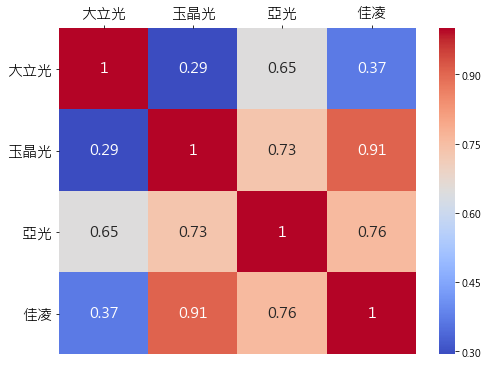

In [24]:
#繪製股票清單調整後收盤價相關係數熱度圖
plot_corr_heatmap(adjclose)

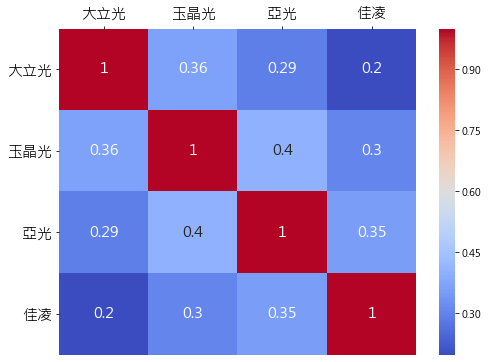

In [25]:
#繪製股票清單調整後收盤價變化率相關係數熱度圖
plot_corr_heatmap(adjclose.pct_change(1))

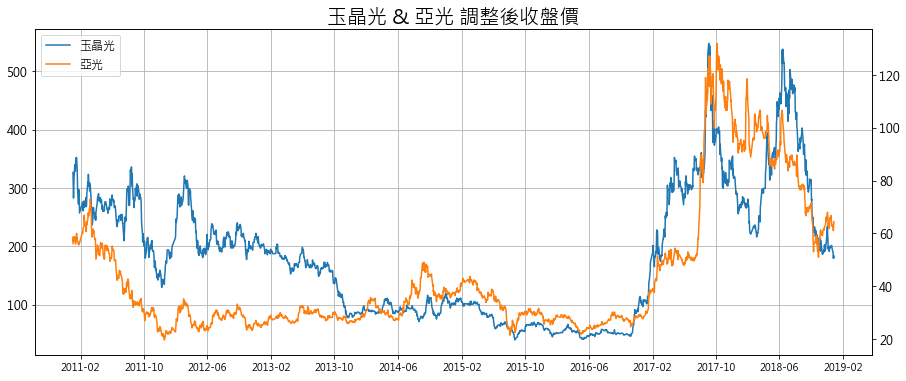

In [26]:
#選擇調整後收盤價變化率相關係數最高的兩檔股票作配對交易
stock_1='玉晶光'
stock_2='亞光'

#繪製配對交易股票價格
plot_pair_stock_price(stock_1,stock_2)

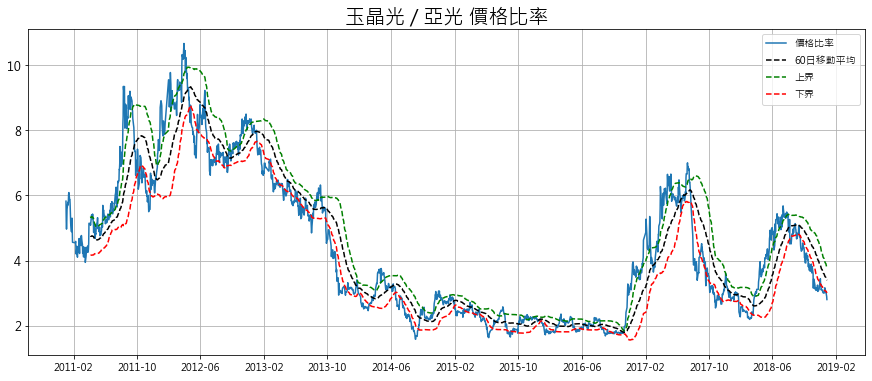

In [27]:
#設定布林通道參數
window=60
crit=1

#繪製和計算Spread_Ratio
plot_spread_ratio(stock_1,stock_2,window,crit)

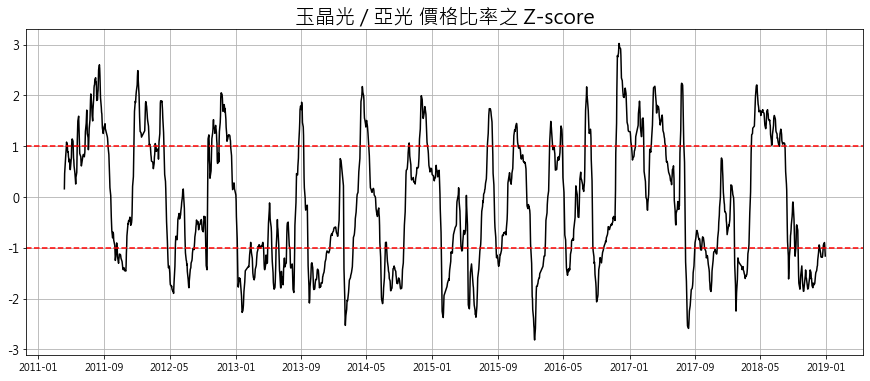

In [28]:
len_1=5
len_2=60

#繪製和計算Z-score策略
z_score=calculate_z_score_strategy(stock_1,stock_2,len_1,len_2)
plot_z_score_strategy(stock_1,stock_2,len_1,len_2)

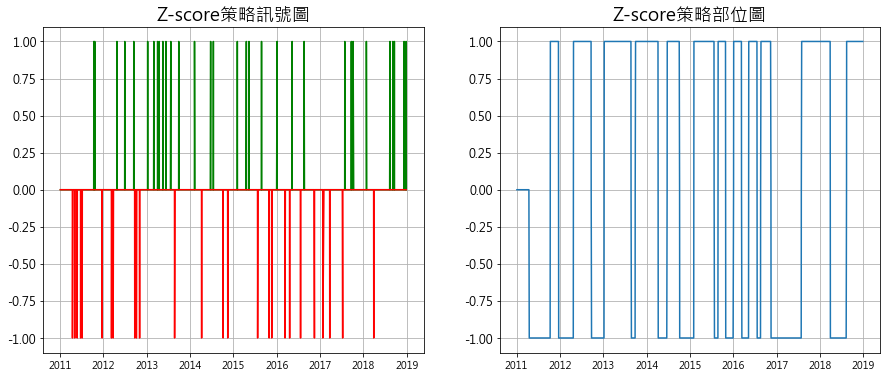

In [29]:
#繪製和計算策略訊號和持有部位
signal_df,position_df=calculate_signal_position(z_score)
plot_signal_position(z_score)

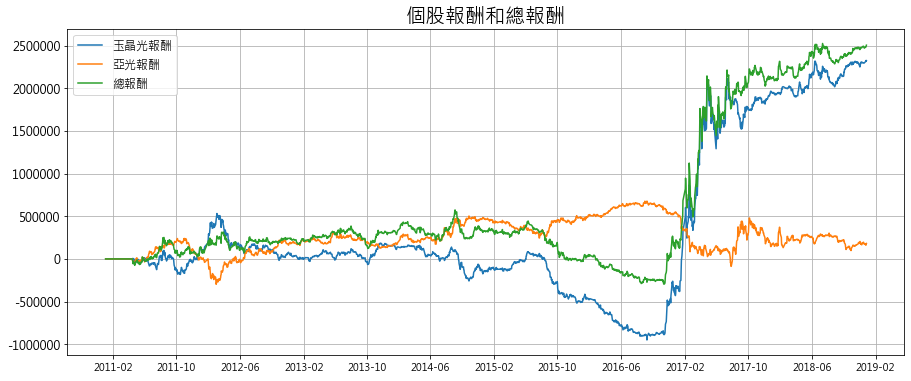

In [30]:
#假設初始資金NT$1000000
wealth=1000000

#繪製和計算交易報酬
trade_return_df,cum_trade_return_df=calculate_return(wealth,signal_df,position_df,adjclose,stock_1,stock_2)
plot_return(wealth,signal_df,position_df,adjclose,stock_1,stock_2)

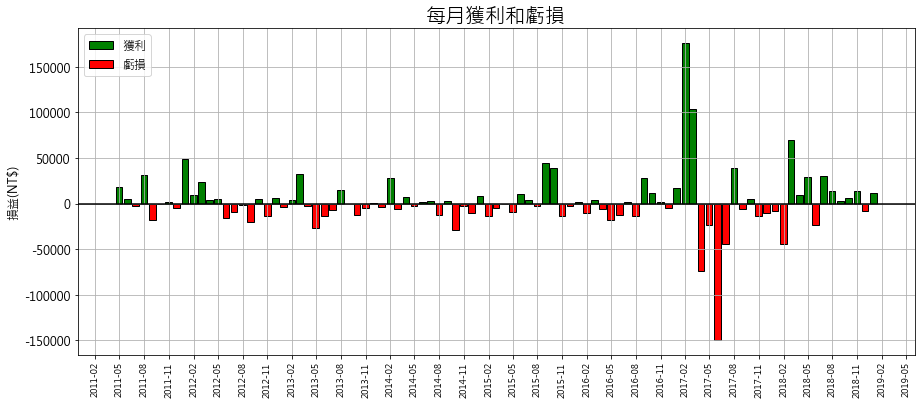

In [31]:
#繪製和計算每月獲利及虧損
month_returns=plot_month_return(trade_return_df)

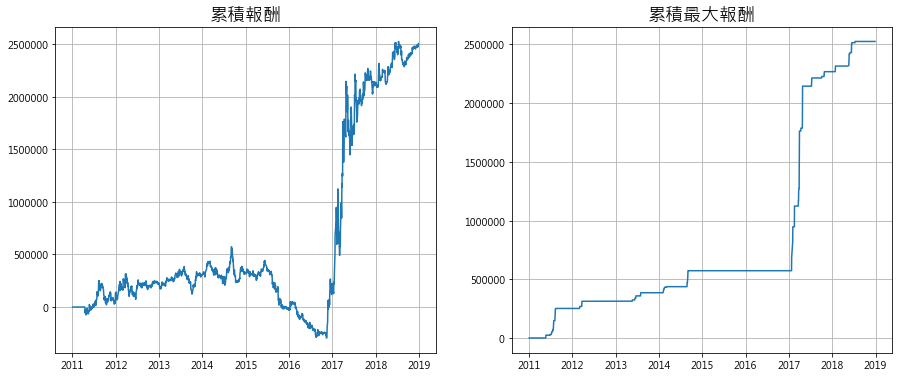

In [32]:
#繪製和計算累積報酬及累積最大報酬
cum_return_series,cummax_return_series,cum_return=calculate_cummax_return(cum_trade_return_df)
plot_cummax_return(cum_trade_return_df)

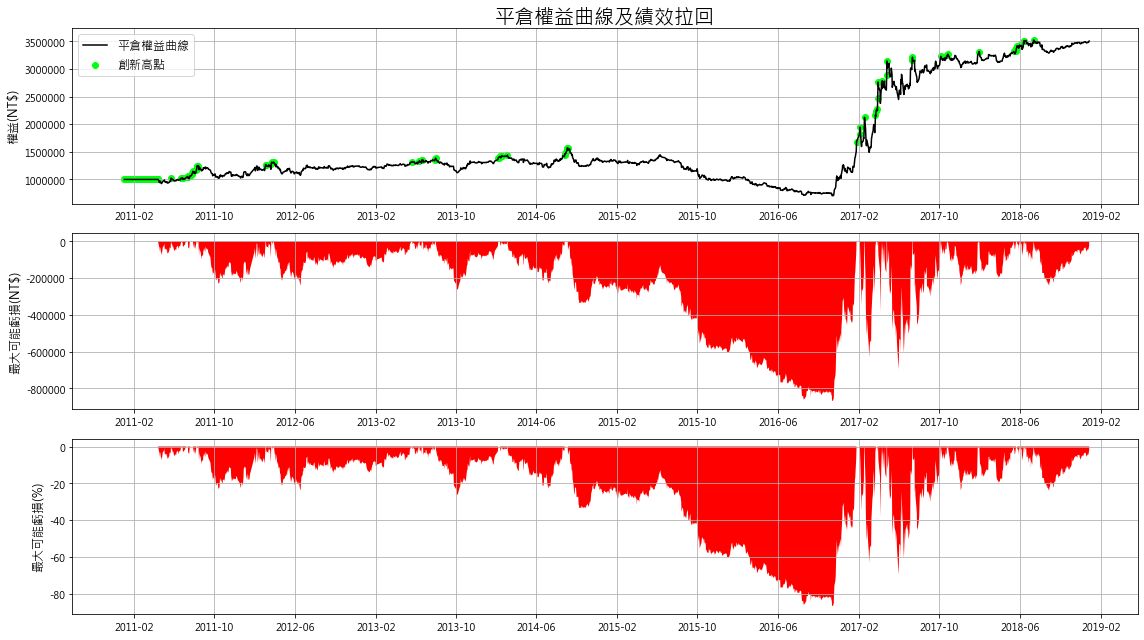

In [33]:
#繪製和計算平倉權益曲線及績效拉回
MDD_series,MDD_ratio_series,MDD,MDD_ratio,return_on_MDD=calculate_MDD(cum_return_series,cummax_return_series,cum_return,wealth)
plot_MDD(cum_return_series,cummax_return_series,wealth)

In [34]:
#計算策略績效
print('淨利(NI): {}'.format(cum_return))
print('最大策略虧損(MDD): {}'.format(MDD))
print('最大策略虧損比例(MDD Ratio): {}%'.format(MDD_ratio))
print('最大策略虧損報酬(Return on MDD): {}'.format(return_on_MDD))

淨利(NI): 2504660.73
最大策略虧損(MDD): 867071.75
最大策略虧損比例(MDD Ratio): 86.71%
最大策略虧損報酬(Return on MDD): 2.89


In [35]:
#計算參數最佳化結果
optimize_df=calculate_optimize_df(stock_1,stock_2)

c:\users\黃子瑋\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


len1:1 , len2:5 , return:5192970.93 , return on MDD:30.81
len1:1 , len2:15 , return:3843505.2 , return on MDD:19.87
len1:1 , len2:25 , return:3501259.93 , return on MDD:4.88
len1:1 , len2:35 , return:4434622.06 , return on MDD:6.18
len1:1 , len2:45 , return:3811763.95 , return on MDD:4.9
len1:3 , len2:5 , return:0.0 , return on MDD:nan
len1:3 , len2:15 , return:2101614.02 , return on MDD:5.09
len1:3 , len2:25 , return:2397753.14 , return on MDD:3.11
len1:3 , len2:35 , return:3634938.26 , return on MDD:5.18
len1:3 , len2:45 , return:2790415.65 , return on MDD:3.69
len1:5 , len2:5 , return:0.0 , return on MDD:nan
len1:5 , len2:15 , return:1888896.39 , return on MDD:4.83
len1:5 , len2:25 , return:1874507.0 , return on MDD:1.99
len1:5 , len2:35 , return:3038777.7 , return on MDD:3.85
len1:5 , len2:45 , return:2034924.5 , return on MDD:2.6
len1:7 , len2:5 , return:534711.75 , return on MDD:0.56
len1:7 , len2:15 , return:402609.12 , return on MDD:0.31
len1:7 , len2:25 , return:1958700.36 , r

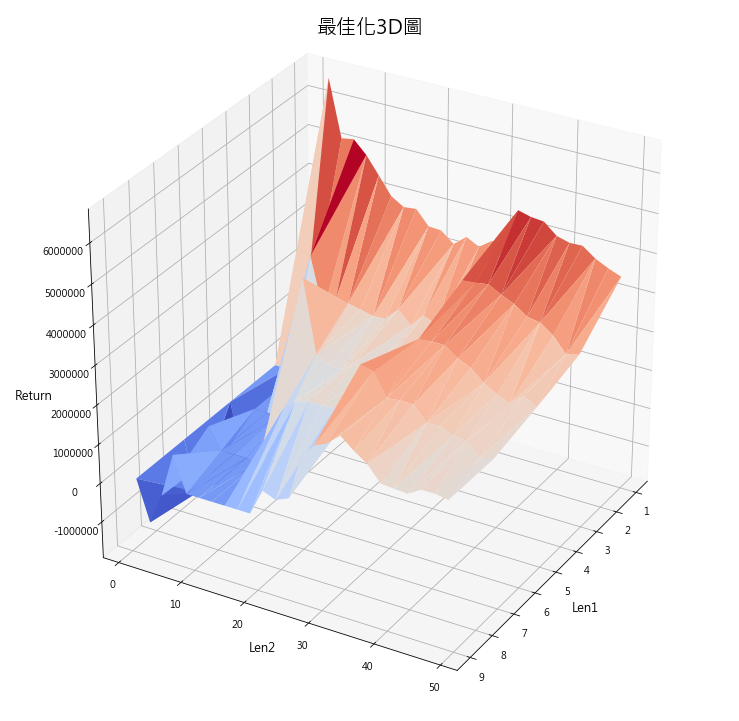

In [36]:
#繪製最佳化3D圖
plot_optimize(optimize_df)

# 選擇最佳化參數下全樣本績效

In [37]:
#呼叫抓取股票清單股價資料函數
stock_price,adjclose=get_price_df(start,end,company_list,code_list)

3008 大立光
3406 玉晶光
3019 亞光
4976 佳凌


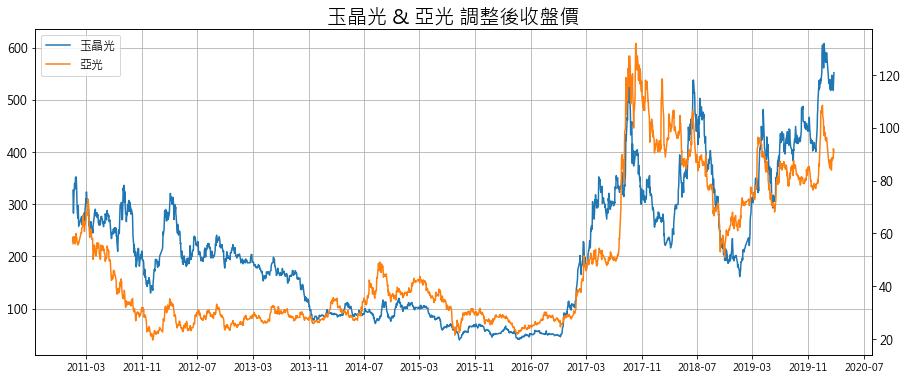

In [38]:
#選擇調整後收盤價變化率相關係數最高的兩檔股票作配對交易
stock_1='玉晶光'
stock_2='亞光'

#繪製配對交易股票價格
plot_pair_stock_price(stock_1,stock_2)

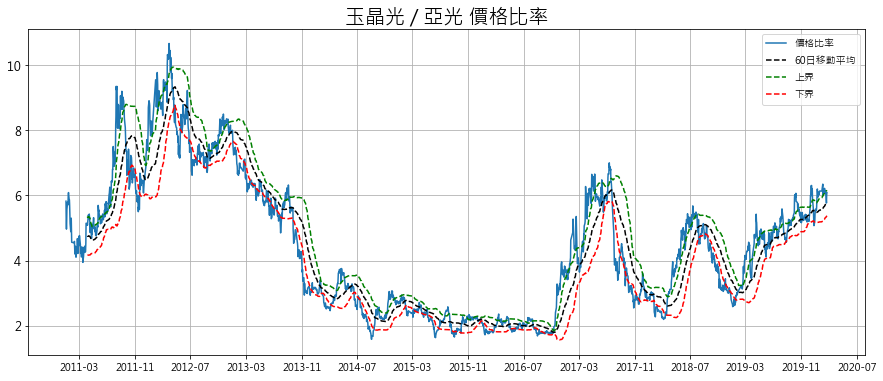

In [39]:
#設定布林通道參數
window=60
crit=1

#繪製和計算Spread_Ratio
plot_spread_ratio(stock_1,stock_2,window,crit)

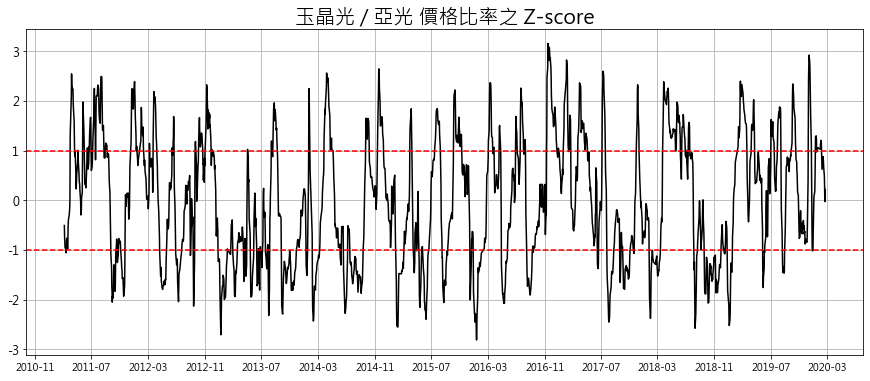

In [40]:
#選擇最佳化參數
len_1=3
len_2=39

#繪製和計算Z-score策略
z_score=calculate_z_score_strategy(stock_1,stock_2,len_1,len_2)
plot_z_score_strategy(stock_1,stock_2,len_1,len_2)

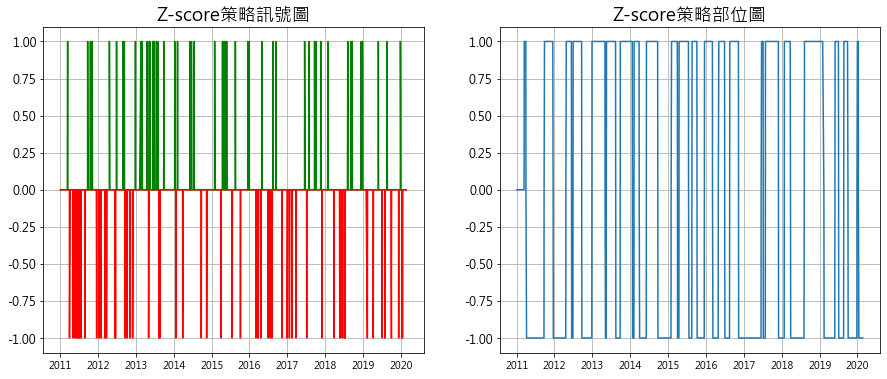

In [41]:
#繪製和計算策略訊號和持有部位
signal_df,position_df=calculate_signal_position(z_score)
plot_signal_position(z_score)

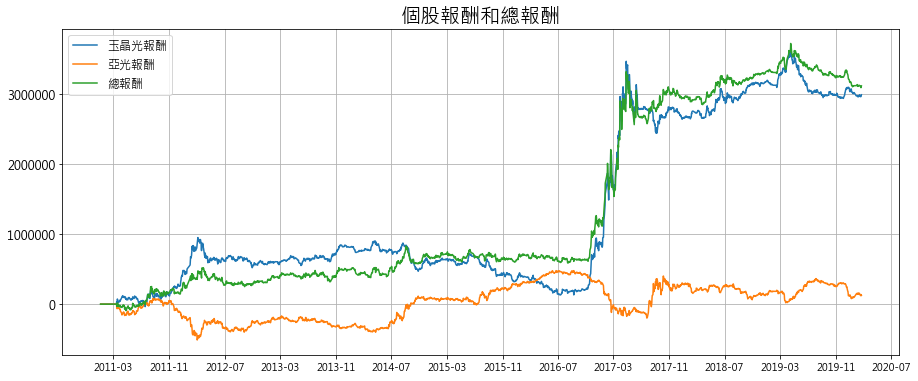

In [42]:
#假設初始資金NT$1000000
wealth=1000000

#繪製和計算交易報酬
trade_return_df,cum_trade_return_df=calculate_return(wealth,signal_df,position_df,adjclose,stock_1,stock_2)
plot_return(wealth,signal_df,position_df,adjclose,stock_1,stock_2)

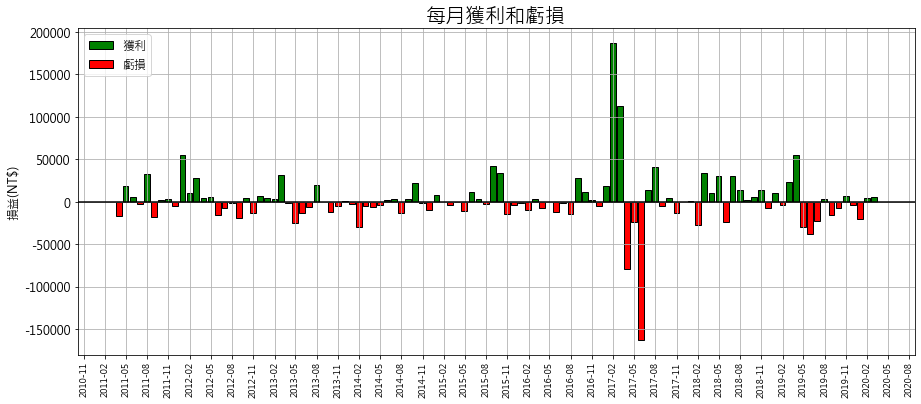

In [43]:
#繪製和計算每月獲利及虧損
month_returns=plot_month_return(trade_return_df)

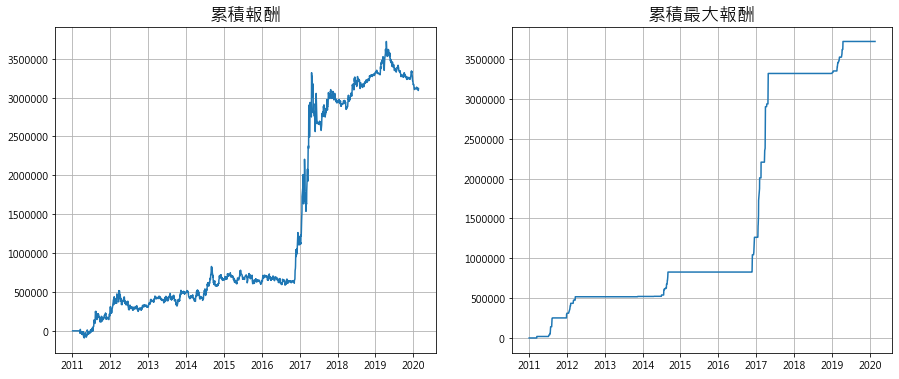

In [44]:
#繪製和計算累積報酬及累積最大報酬
cum_return_series,cummax_return_series,cum_return=calculate_cummax_return(cum_trade_return_df)
plot_cummax_return(cum_trade_return_df)

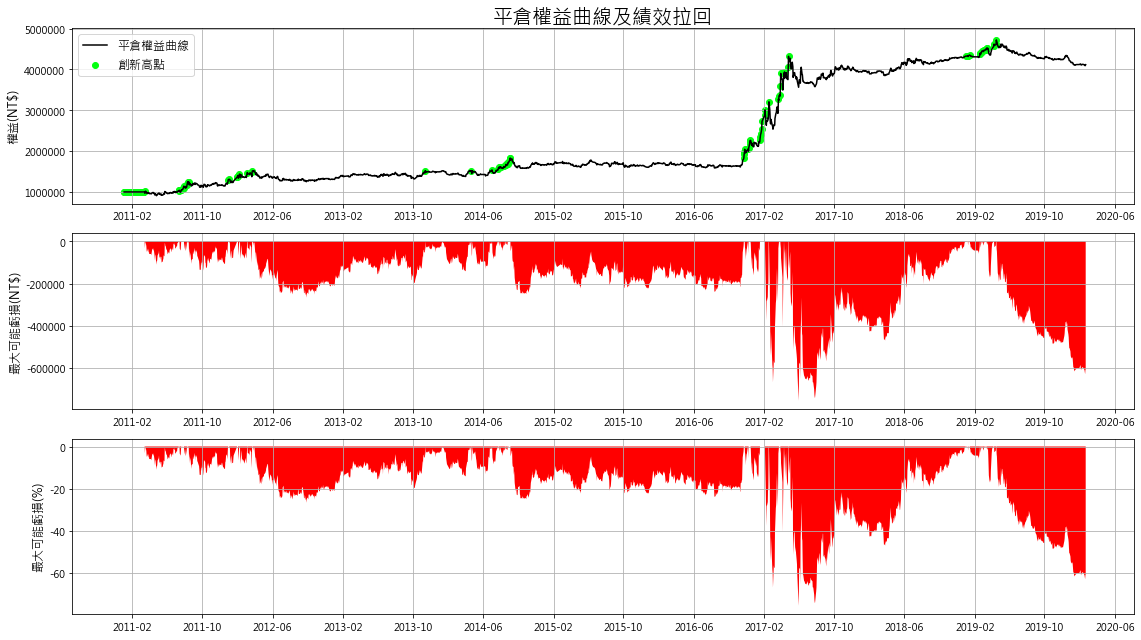

In [45]:
#繪製和計算平倉權益曲線及績效拉回
MDD_series,MDD_ratio_series,MDD,MDD_ratio,return_on_MDD=calculate_MDD(cum_return_series,cummax_return_series,cum_return,wealth)
plot_MDD(cum_return_series,cummax_return_series,wealth)

In [46]:
#計算策略績效
print('淨利(NI): {}'.format(cum_return))
print('最大策略虧損(MDD): {}'.format(MDD))
print('最大策略虧損比例(MDD Ratio): {}%'.format(MDD_ratio))
print('最大策略虧損報酬(Return on MDD): {}'.format(return_on_MDD))

淨利(NI): 3114716.63
最大策略虧損(MDD): 756958.27
最大策略虧損比例(MDD Ratio): 75.7%
最大策略虧損報酬(Return on MDD): 4.11
